In [112]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.signal as signal
import pandas as pd
from sklearn.decomposition import PCA
import math
import warnings
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import col
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

warnings.filterwarnings('ignore')

## Load & Explore Data

### Perform EDA & Pre-processing on random sample of 3 activities

In [2]:
# Load exercise dataset 
exercise_dataset = scipy.io.loadmat('bigfiles/exercise_data.50.0000_singleonly.mat', struct_as_record=False)

# Load activities and data full objects
exercise_constants = exercise_dataset['exerciseConstants'][0][0].activities
subject_data = exercise_dataset['subject_data']

# extract activities names into an array
all_activities = []
for act in exercise_constants[0]:
    all_activities.append(act[0])

In [3]:
activities_to_remove = ['Tap Left Device', 'Tap Right Device', 'Device on Table', 
'Non-Exercise', 'Note', 'Unlisted Exercise', 'Rest',
'Arm Band Adjustment', '<Initial Activity>', 'Invalid', 'Arm straight up', 
'Tap IMU Device', 'Triceps extension (lying down) (left arm)',
'Triceps extension (lying down) (right arm)', 'Alternating Dumbbell Curl']

# remove activities from all_activities
for activity in activities_to_remove:
    all_activities.remove(activity)

In [4]:
# only take data from 3 random exercises
activities_to_process = random.choices(all_activities, k=3)
print(activities_to_process)

['Dumbbell Row (knee on bench) (left arm)', 'Lateral Raise', 'Squat (hands behind head)']


In [5]:
# define dictionaries for accelerometer and gyroscope data
activities_accelerometer_data_dict = { activities_to_process[0]: [], activities_to_process[1]: [], activities_to_process[2]: []}
activities_gyroscope_data_dict = { activities_to_process[0]: [], activities_to_process[1]: [], activities_to_process[2]: []}
rep_counts_actual = []

# iterate over subject data to search for those activities and save the data related
for data_item in subject_data:
    for x in data_item:
        if len(x) > 0:
            if x[0] is not None and len(x[0]) > 0:
                data_activity_name = x[0,0].activityName[0]
                data_activity_reps = x[0,0].activityReps[0]
                data_item_accelDataMatrix = x[0,0].data[0,0].accelDataMatrix
                data_item_gyroDataMatrix = x[0,0].data[0,0].gyroDataMatrix
                if data_activity_name in activities_to_process:
                    activities_accelerometer_data_dict[data_activity_name].append(data_item_accelDataMatrix)
                    activities_gyroscope_data_dict[data_activity_name].append(data_item_gyroDataMatrix)
                    rep_counts_actual.append(data_activity_reps)

In [6]:
# turn activities_gyroscope_data_dict and activities_accelerometer_data_dict into a spark dataframe
ss = SparkSession.builder.getOrCreate()
sc = ss.sparkContext
sc.setLogLevel("ERROR")

# create schema for data
schema = StructType([
    StructField("overall_set_num", IntegerType(), True),
    StructField("activity_name", StringType(), True),
    StructField("activity_set_num", IntegerType(), True),
    StructField("time", DoubleType(), True),
    StructField("x", DoubleType(), True),
    StructField("y", DoubleType(), True),
    StructField("z", DoubleType(), True)
])

# create empty dataframes
gyroscope_df = ss.createDataFrame(sc.emptyRDD(), schema)
accelerometer_df = ss.createDataFrame(sc.emptyRDD(), schema)
gyroscope_data = []
accelerometer_data = []
# Iterate over activities and append data to dataframes
overall_set_num = 0
for activity in activities_to_process:
    for activity_set_num, activity_set in enumerate(activities_gyroscope_data_dict[activity]):
        for time_point in activity_set:
            data_row = (overall_set_num, str(activity), activity_set_num, float(time_point[0]), float(time_point[1]), float(time_point[2]), float(time_point[3]))
            gyroscope_data.append(data_row)
        overall_set_num += 1
    overall_set_num -= activity_set_num
    for activity_set_num, activity_set in enumerate(activities_accelerometer_data_dict[activity]):
        for time_point in activity_set:
            data_row = (overall_set_num, str(activity), activity_set_num, float(time_point[0]), float(time_point[1]), float(time_point[2]), float(time_point[3]))
            accelerometer_data.append(data_row)
        overall_set_num += 1

# Create dataframes directly from the lists of data rows
gyroscope_df = ss.createDataFrame(gyroscope_data, schema)
accelerometer_df = ss.createDataFrame(accelerometer_data, schema)

23/06/22 22:14:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/22 22:15:10 WARN TaskSetManager: Stage 0 contains a task of very large size (1364 KiB). The maximum recommended task size is 1000 KiB.


+---------------+--------------------+----------------+------------------+--------------------+--------------------+------------------+
|overall_set_num|       activity_name|activity_set_num|              time|                   x|                   y|                 z|
+---------------+--------------------+----------------+------------------+--------------------+--------------------+------------------+
|              0|Dumbbell Row (kne...|               0|202.97801843365608| -1.9447947566837775|   -2.77654081162295|  2.52696244866429|
|              0|Dumbbell Row (kne...|               0| 202.9980182384086| -0.5094012683693533| -3.7902601095117525| 3.066467551166236|
|              0|Dumbbell Row (kne...|               0| 203.0180180431612|  -2.137812267492277|  -2.659574152639015|2.1531946107244306|
|              0|Dumbbell Row (kne...|               0|203.03801784791372|  -7.749380677894964| -1.4932860087047457| 2.158961057739877|
|              0|Dumbbell Row (kne...|          

23/06/22 22:15:12 WARN TaskSetManager: Stage 1 contains a task of very large size (1364 KiB). The maximum recommended task size is 1000 KiB.


In [9]:
# save dataframes to csv
gyroscope_df.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("bigfiles/gyroscope_data0620.csv")
accelerometer_df.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("bigfiles/accelerometer_data0620.csv")

# load dataframes from csv
#gyroscope_df = ss.read.csv("bigfiles/gyroscope_data.csv", header=True, inferSchema=True)
#accelerometer_df = ss.read.csv("bigfiles/accelerometer_data.csv", header=True, inferSchema=True)


23/06/22 22:18:28 WARN TaskSetManager: Stage 2 contains a task of very large size (8646 KiB). The maximum recommended task size is 1000 KiB.
23/06/22 22:18:29 WARN TaskSetManager: Stage 3 contains a task of very large size (8646 KiB). The maximum recommended task size is 1000 KiB.


### Visualizations

#### Accelerometer Measurements chart (only the first result of exercises per activity has been taken)

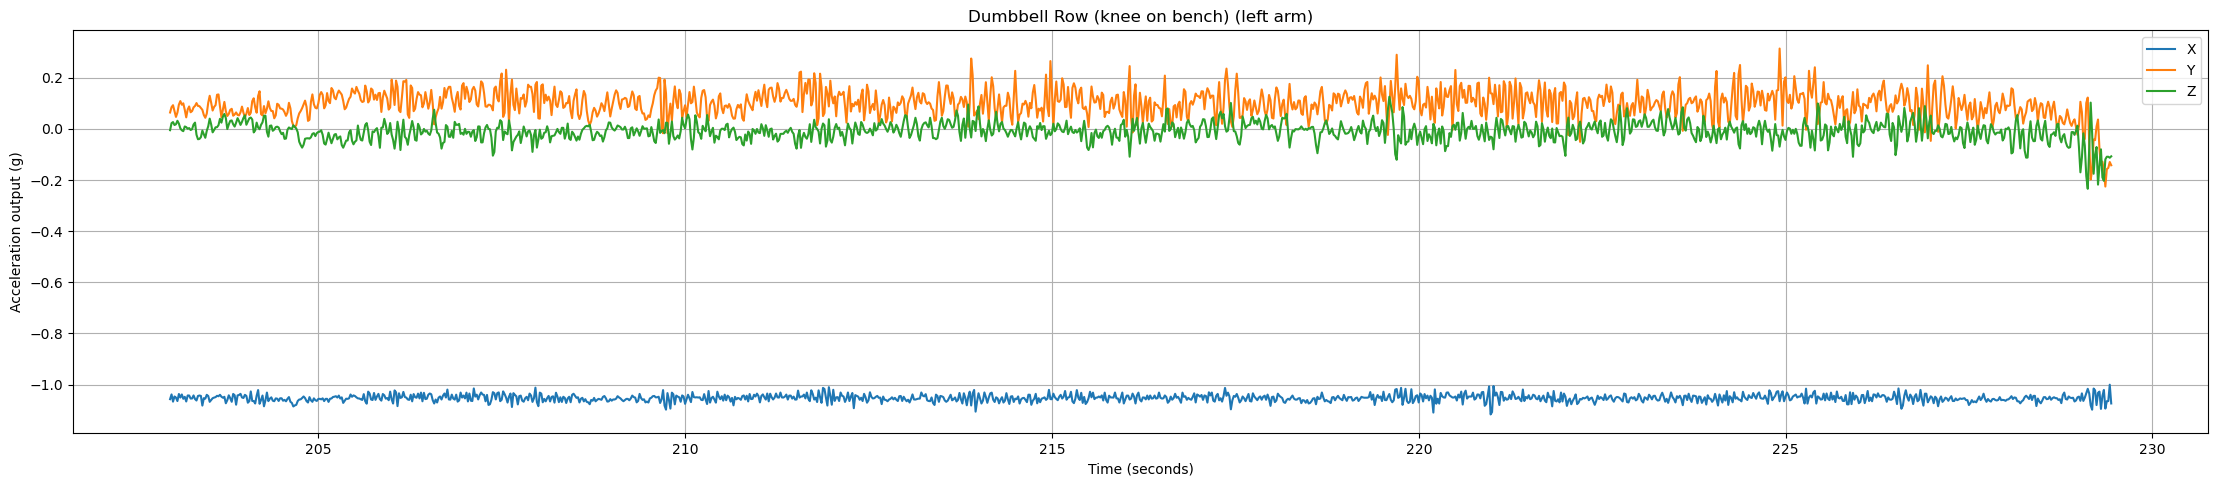

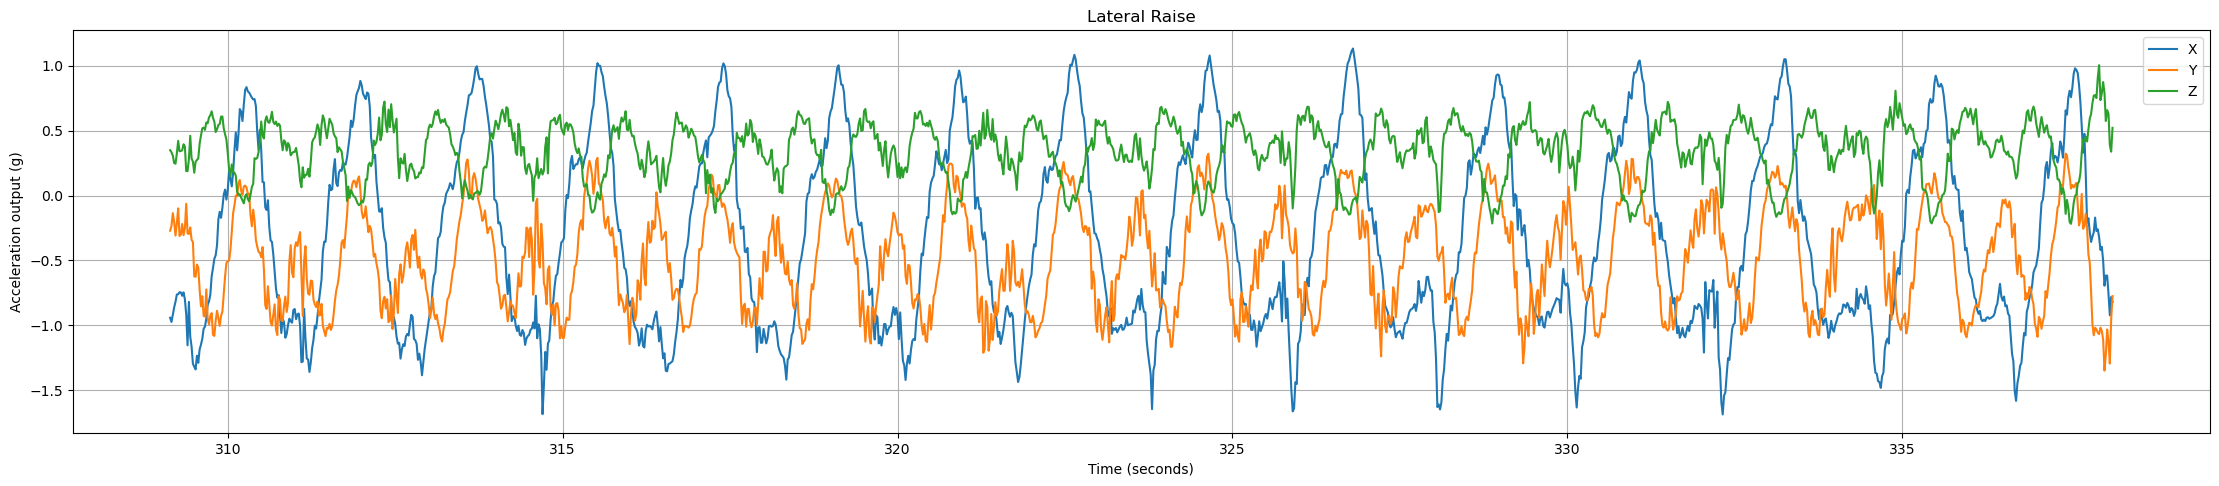

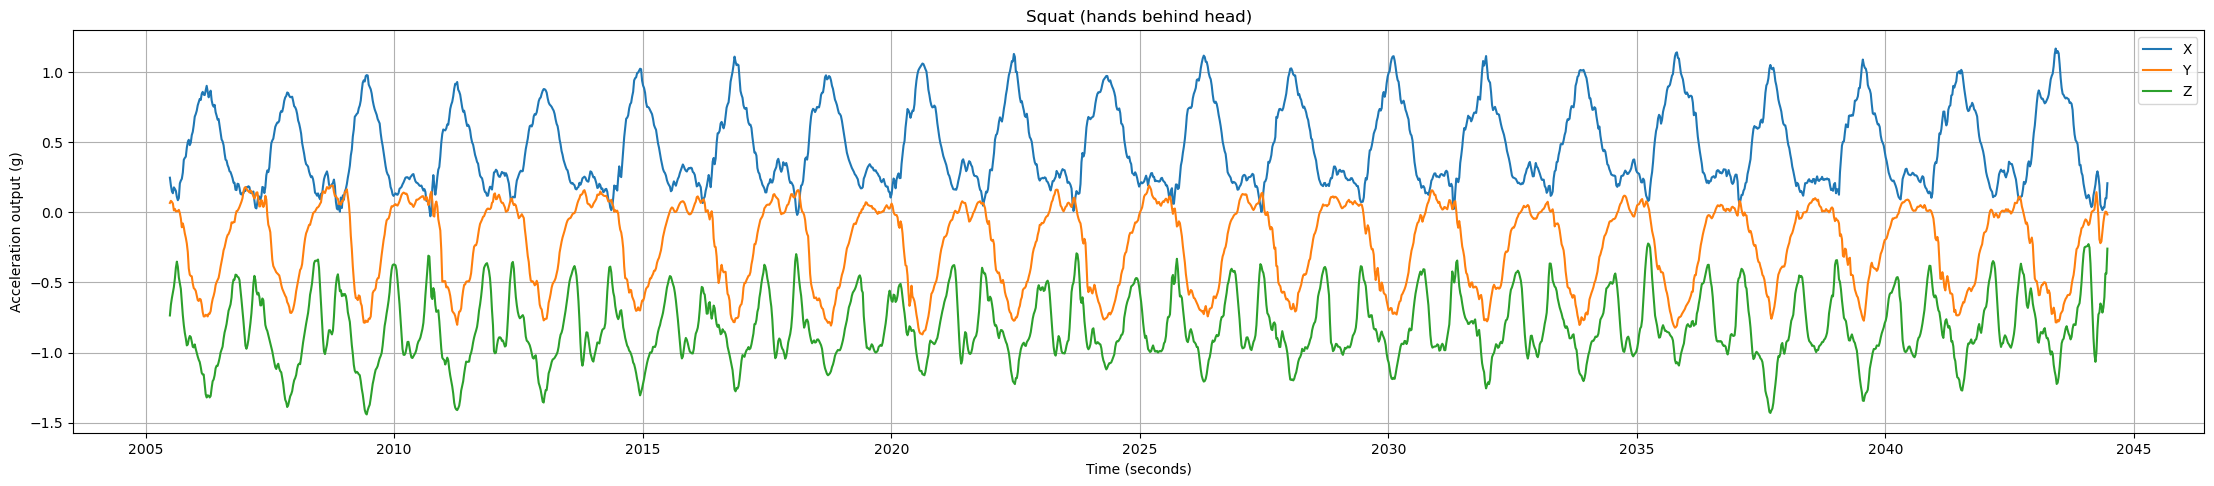

In [7]:
# Data to graph
for activity in activities_to_process:
       t, x, y, z = [], [], [], []

       for data_activity in activities_accelerometer_data_dict[activity][0]: # take only the values corresponding to the results of the first excersise
              t.append(data_activity[0]) # time value
              x.append(data_activity[1]) # X value
              y.append(data_activity[2]) # Y value
              z.append(data_activity[3]) # Z value

       fig, ax = plt.subplots()
       ax.plot(t, x, label = 'X')
       ax.plot(t, y, label = 'Y')
       ax.plot(t, z, label = 'Z')

       ax.set(xlabel='Time (seconds)', ylabel='Acceleration output (g)', title=activity)
       ax.grid()

       fig.tight_layout()
       fig.set_size_inches(25, 5)

       plt.legend()
       plt.show()

#### Gyroscope Measurements chart (only the first result of exercises per activity has been taken)

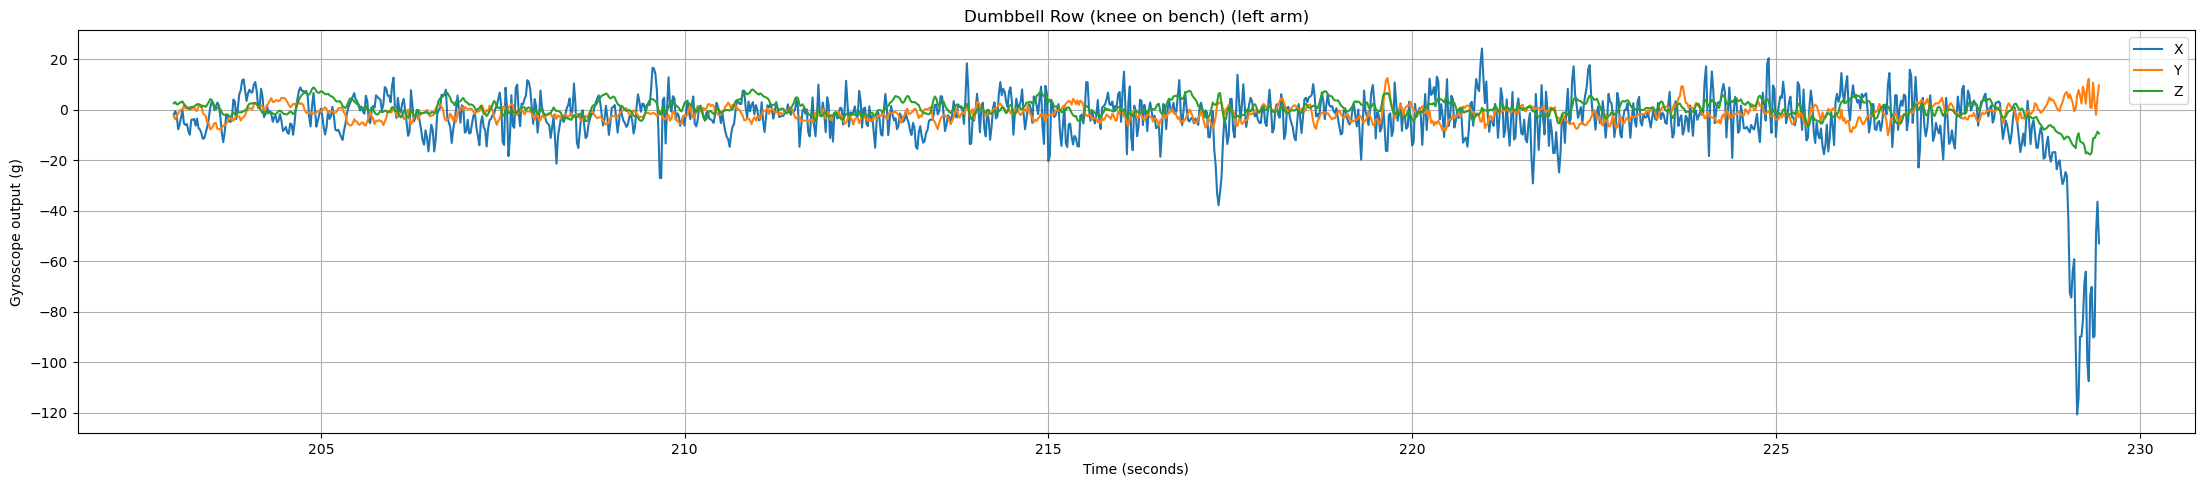

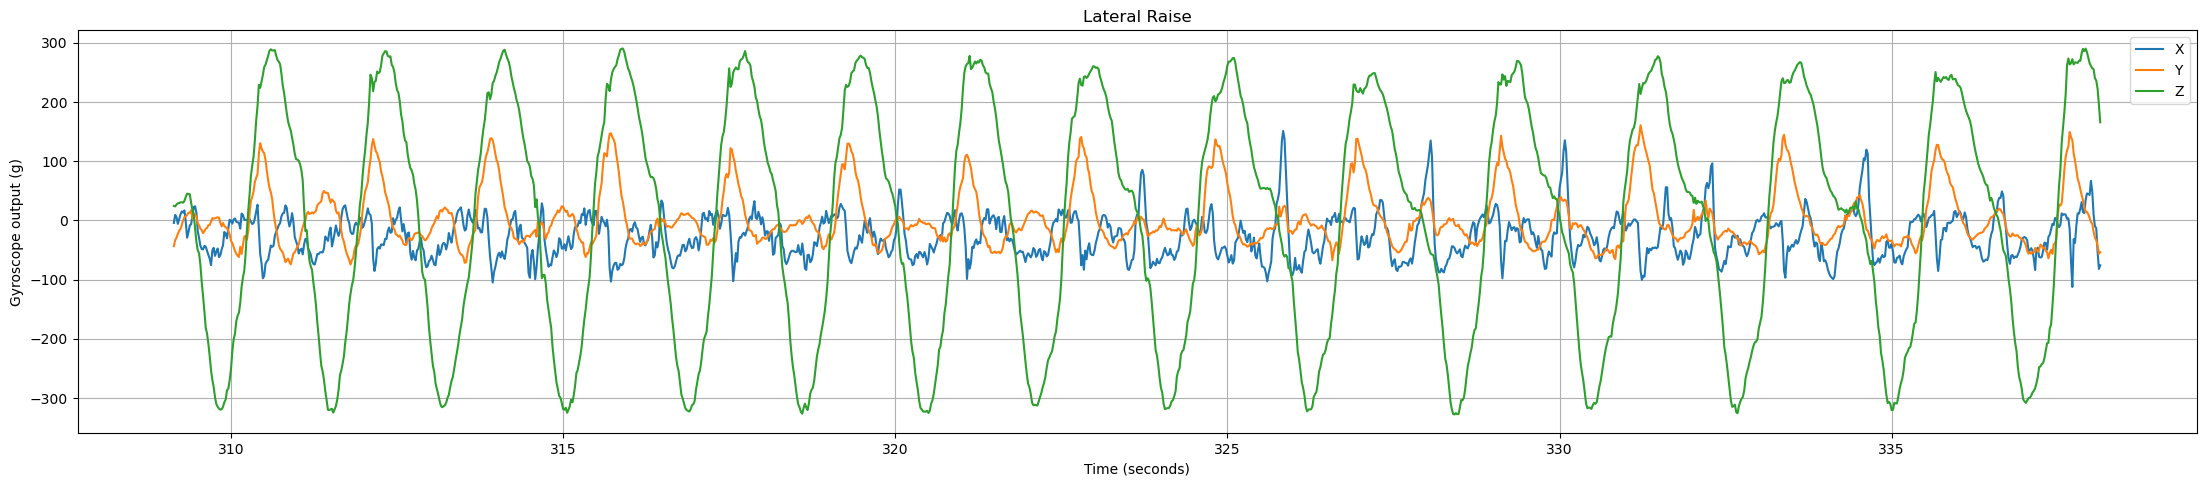

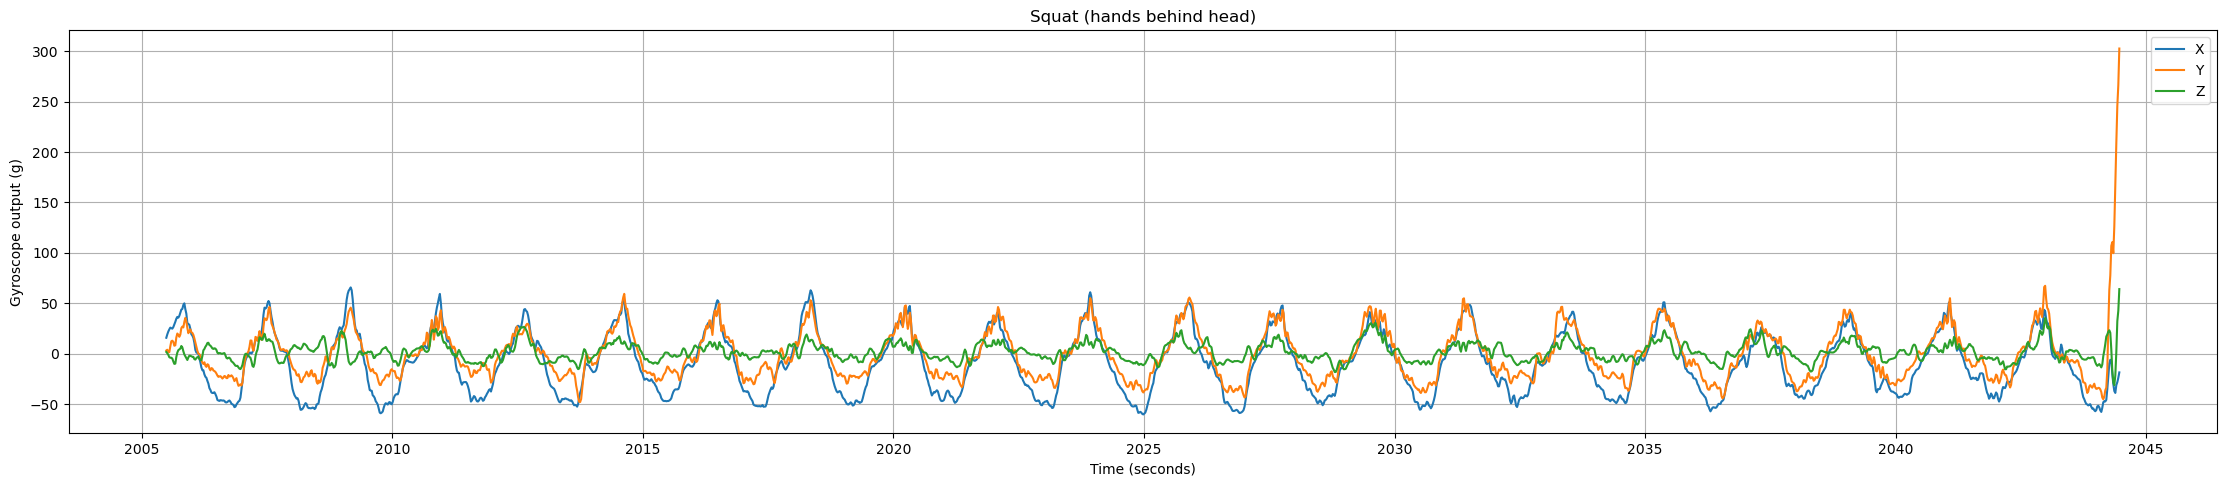

In [8]:
# Data to graph
for activity in activities_to_process:
       t, x, y, z = [], [], [], []

       for data_activity in activities_gyroscope_data_dict[activity][0]: # take only the values corresponding to the results of the first excersise
              t.append(data_activity[0]) # time value
              x.append(data_activity[1]) # X value
              y.append(data_activity[2]) # Y value
              z.append(data_activity[3]) # Z value

       fig, ax = plt.subplots()
       ax.plot(t, x, label = 'X')
       ax.plot(t, y, label = 'Y')
       ax.plot(t, z, label = 'Z')

       ax.set(xlabel='Time (seconds)', ylabel='Gyroscope output (g)', title=activity)
       ax.grid()

       fig.tight_layout()
       fig.set_size_inches(25, 5)

       plt.legend()
       plt.show()

## Segmentation Pre-Processing
Given data points containing x,y,z, and time, how would you smooth this data with a Butterworth low-pass filter (-60dB at 20Hz), then windowed into 5-second windows sliding at 1/50 of a second (i.e., each 5s window shares 4.8s of data with the previous window)

In [185]:
def magnitude(x, y, z):
    return math.sqrt(x**2 + y**2 + z**2)

def apply_butterworth_lowpass(data):
    sampling_rate = 50 # sampling_rate of 50 Hz
    cutoff_frequency = 0.2  # Cutoff frequency of 0.2 Hz
    filter_order = 4  # Specify the desired filter order (try different values)
    nyquist_frequency = 0.5 * sampling_rate  
    normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency
    b, a = signal.butter(filter_order, normalized_cutoff_frequency, btype='low', analog=False, output='ba')
    smoothed_data = signal.lfilter(b, a, data)
    return smoothed_data#.flatten()

# Initialize a dictionary windowed_smoothed_data with keys as activities_to_process and corresponding values as empty lists
windowed_smoothed_data = {activity: [] for activity in activities_to_process}

# Assuming 'x', 'y', 'z', and 'time' are your data arrays in seconds
N = 4  # Filter order
sampling_rate = 1.0  # Sampling rate of 1 Hz
cutoff_frequency = 0.2  # Cutoff frequency of 0.2 Hz
filter_order = N  # Specify the desired filter order

mag_cols = udf(magnitude, DoubleType())
butterworth_filter = udf(lambda x:apply_butterworth_lowpass(x), DoubleType()) 


In [ ]:
# def preprocess(data_source, source_name):
#     window_duration = 5  # Window duration in seconds
#     sampling_rate = 50  # Sampling rate in Hz
#     window_size = int(window_duration * sampling_rate) # 250
#     overlap = int((window_duration - 0.2) * sampling_rate) # 4.8 seconds = 240 overlap

#     windowed_smoothed_data_table = {f"{col}{i}": [] for col in ['t', source_name+'_x', 
#                                     source_name+'_y', source_name+'_z', source_name+'rawx'] 
#                                     for i in range(window_size)}
#     windowed_smoothed_data_table['overall_set_num'] = []
#     windowed_smoothed_data_table['activity_name'] = []
#     windowed_smoothed_data_table['activity_set_num'] = []

#     overall_set_nums = data_source.select('overall_set_num').distinct().rdd.flatMap(lambda x: x).collect()

#     for overall_set_num in overall_set_nums:
#         set_data = data_source.filter(data_source.overall_set_num == overall_set_num)
#         smoothed_t = list(set_data.select(set_data['time']).toPandas()['time'])
#         smoothed_x = list(set_data.select(set_data['x']).toPandas()['x'])
#         smoothed_y = list(set_data.select(set_data['y']).toPandas()['y'])
#         smoothed_z = list(set_data.select(set_data['z']).toPandas()['z'])
#         rawx = list(set_data.select(set_data['x']).toPandas()['x'])
        
#         activity_name = set_data.select('activity_name').first()[0]
#         activity_set_num = set_data.select('activity_set_num').first()[0]

#         # Slide the window over the smoothed data
#         for i in range(0, len(smoothed_x) - window_size + 1, overlap):
#             windowed_smoothed_data_table['overall_set_num'].append(overall_set_num)
#             windowed_smoothed_data_table['activity_name'].append(activity_name)
#             windowed_smoothed_data_table['activity_set_num'].append(activity_set_num)

#             for j in range(window_size):
#                 windowed_smoothed_data_table[f"t{j}"].append(smoothed_t[i + j])
#                 windowed_smoothed_data_table[f"{source_name}_x{j}"].append(smoothed_x[i + j])
#                 windowed_smoothed_data_table[f"{source_name}_y{j}"].append(smoothed_y[i + j])
#                 windowed_smoothed_data_table[f"{source_name}_z{j}"].append(smoothed_z[i + j])
#                 windowed_smoothed_data_table[f"{source_name}_rawx{j}"].append(rawx[i + j])

#     df = ss.createDataFrame(pd.DataFrame(windowed_smoothed_data_table))
#     return df


In [202]:
def preprocess(data_source, source_name):
    window_duration = 5  # Window duration in seconds
    sampling_rate = 50  # Sampling rate in Hz
    window_size = int(window_duration * sampling_rate) # 250
    overlap = 10 # distinct 10 points 200ms, shared 4.8 seconds => 240 overlap

    windowed_smoothed_data_table = {f"{col}{i}": [] for col in ['t', source_name+'_x', 
                                    source_name+'_y', source_name+'_z', source_name+'_rawx', source_name+'_mag'] 
                                    for i in range(window_size)}
    windowed_smoothed_data_table['overall_set_num'] = []
    windowed_smoothed_data_table['activity_name'] = []
    windowed_smoothed_data_table['activity_set_num'] = []

    # iterate over all distinct set_nums in the data table
    # so that we can process 1 exercise set's signal in all 4 dimensions (x, y, z, t) at a time
    overall_set_nums = data_source.select('overall_set_num').distinct().rdd.flatMap(lambda x: x).collect()
    for overall_set_num in overall_set_nums[:-1]: # TODO update index
        # get current set information
        set_data = data_source.filter(data_source.overall_set_num == overall_set_num)
        activity_name = set_data.select('activity_name').first()[0]
        activity_set_num = set_data.select('activity_set_num').first()[0]

        # normalize the x, y, z columns
        # columns_to_scale = ["x", "y", "z"]
        # assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
        # scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
        # pipeline = Pipeline(stages=assemblers + scalers)
        # scalerModel = pipeline.fit(set_data)
        # scaledData = scalerModel.transform(set_data)

        # apply butterworth lowpass filter to x, y, z columns
        scaled_x = list(set_data.select(set_data['x']).toPandas()['x'])
        scaled_y = list(set_data.select(set_data['y']).toPandas()['y'])
        scaled_z = list(set_data.select(set_data['z']).toPandas()['z'])

        # scaledData = scaledData.withColumn("x_smoothed", )
        # scaledData = scaledData.withColumn("y_smoothed", apply_butterworth_lowpass(scaled_y))
        # scaledData = scaledData.withColumn("z_smoothed", apply_butterworth_lowpass(scaled_z))
        
        # smoothed_scaledData = scaledData.withColumn("x_smoothed", apply_butterworth_lowpass(col("x_scaled")))
        # smoothed_scaledData = scaledData.withColumn("y_smoothed", apply_butterworth_lowpass(col("y_scaled")))
        # smoothed_scaledData = scaledData.withColumn("z_smoothed", apply_butterworth_lowpass(col("z_scaled")))

        smoothed_df = pd.DataFrame.from_dict({
            "x_smoothed": apply_butterworth_lowpass(scaled_x),
            "y_smoothed": apply_butterworth_lowpass(scaled_y),
            "z_smoothed": apply_butterworth_lowpass(scaled_z),
        })
        set_smoothed_data_table = ss.createDataFrame(smoothed_df) 
        
        # scaledData = scaledData.join(set_smoothed_data_table)
        # print("done joining")
        
        # turn columns to lists
        time = list(set_data.select(scaledData['time']).toPandas()['time'])
        smoothed_x = smoothed_df.x_smoothed
        smoothed_y = smoothed_df.y_smoothed
        smoothed_z = smoothed_df.z_smoothed
        mag = np.sqrt(smoothed_x**2 + smoothed_y**2 + smoothed_z**2)
        #smoothed_y = list(scaledData.select(scaledData['y_smoothed']).toPandas()['y_smoothed'])
        #smoothed_z = list(scaledData.select(scaledData['z_smoothed']).toPandas()['z_smoothed'])

        # feature computation
        # aX: the X-axis accelerometer signal
        rawx = list(set_data.select(set_data['x']).toPandas()['x'])
        # aXmag: the magnitude of the accelerometer signal at each sample, i.e. sqrt(ax2+ay2+az2).
        #set_smoothed_data_table.withColumn(source_name+"_mag",mag_cols(col.x_smoothed, col.y_smoothed, collect_list.z_smoothed)) \
        #    .show()
        #mag = list(set_data.select(set_data[source_name+"_mag"]).toPandas()[source_name+"_mag"])
        

        # Slide the window over the computed features
        for i in range(0, len(smoothed_x) - window_size + 1, overlap):
            windowed_smoothed_data_table['overall_set_num'].append(overall_set_num)
            windowed_smoothed_data_table['activity_name'].append(activity_name)
            windowed_smoothed_data_table['activity_set_num'].append(activity_set_num)

            individual_window_table = {f"{col}{i}": [] for col in ['t', source_name+'_x', 
                                    source_name+'_y', source_name+'_z'] 
                                    for i in range(window_size)}
            for j in range(window_size):
                windowed_smoothed_data_table[f"t{j}"].append(time[i + j])
                windowed_smoothed_data_table[f"{source_name}_x{j}"].append(smoothed_x[i + j])
                windowed_smoothed_data_table[f"{source_name}_y{j}"].append(smoothed_y[i + j])
                windowed_smoothed_data_table[f"{source_name}_z{j}"].append(smoothed_z[i + j])
                windowed_smoothed_data_table[f"{source_name}_rawx{j}"].append(rawx[i + j])
                windowed_smoothed_data_table[f"{source_name}_mag{j}"].append(mag[i + j])

                # get 3 derived signals for each window: aX, aYZPC1, and gPC1
                if data_source == "accelerometer": # compute aX, aYZPC1

                elif data_source == "gyroscope": # compute gPC1


    df = ss.createDataFrame(pd.DataFrame(windowed_smoothed_data_table))
    return df


In [ ]:
# TODO PCA Part
        # aPC1: the projection of the three-dimensional accelerometer signal onto its first principal component



In [212]:
test_g.filter(test_g.overall_set_num == 0).select('t0', 't249').show()

+------------------+------------------+
|                t0|              t249|
+------------------+------------------+
|202.97801843365608|207.95796981704166|
| 203.1780164811816| 208.1579678645672|
| 203.3780145287071| 208.3579659120927|
|203.57801257623265|208.55796395961823|
|203.77801062375818|208.75796200714376|
| 203.9780086712837|208.95796005466931|
|204.17800671880926| 209.1579581021948|
|204.37800476633475|209.35795614972034|
|204.57800281386028| 209.5579541972459|
|204.77800086138578| 209.7579522447714|
|204.97799890891136| 209.9579502922969|
|205.17799695643686|210.15794833982244|
|205.37799500396238|  210.357946387348|
|205.57799305148788| 210.5579444348735|
|205.77799109901343|210.75794248239902|
|205.97798914653896|210.95794052992457|
|206.17798719406449| 211.1579385774501|
|206.37798524159004| 211.3579366249756|
|206.57798328911554|211.55793467250112|
|206.77798133664106|211.75793272002667|
+------------------+------------------+
only showing top 20 rows



In [203]:
test_g = preprocess(gyroscope_df, 'gyroscope')
test_g

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


DataFrame[t0: double, t1: double, t2: double, t3: double, t4: double, t5: double, t6: double, t7: double, t8: double, t9: double, t10: double, t11: double, t12: double, t13: double, t14: double, t15: double, t16: double, t17: double, t18: double, t19: double, t20: double, t21: double, t22: double, t23: double, t24: double, t25: double, t26: double, t27: double, t28: double, t29: double, t30: double, t31: double, t32: double, t33: double, t34: double, t35: double, t36: double, t37: double, t38: double, t39: double, t40: double, t41: double, t42: double, t43: double, t44: double, t45: double, t46: double, t47: double, t48: double, t49: double, t50: double, t51: double, t52: double, t53: double, t54: double, t55: double, t56: double, t57: double, t58: double, t59: double, t60: double, t61: double, t62: double, t63: double, t64: double, t65: double, t66: double, t67: double, t68: double, t69: double, t70: double, t71: double, t72: double, t73: double, t74: double, t75: double, t76: double,

In [64]:
df_gyroscope = preprocess(gyroscope_df, 'gyroscope')

In [65]:
df_accelerometer = preprocess(accelerometer_df, 'accelerometer')

## Segmentation Feature Computation
1) aX: the X-axis accelerometer signal

2) aXmag: the magnitude of the accelerometer signal at each sample, i.e. sqrt(ax2+ay2+az2).

3) aPC1: the projection of the three-dimensional accelerometer signal onto its first principal component. This is the movement along the axis that demonstrates the most variance within this window, or – anecdotally – themost “interesting” rotation of the window.

4) aYZPC1: the projection of only the Y and Z axes onto the first principal component of those two axes. This captures movement perpendicular to the arm, which allows us to derive information from the Y and Z axes despite the unknown rotation of the armband. 

## Join both dataframes

In [66]:
# Define the join condition
join_condition = ["overall_set_num", "activity_name", "activity_set_num"] + [f"t{i}" for i in range(250)]

# Join the dataframes
joined_df = df_gyroscope.join(df_accelerometer, join_condition, "inner")